<a href="https://colab.research.google.com/github/doogzultz/time_series_project/blob/main/preprocessing_and_model_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [821]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pandas.plotting import scatter_matrix
from tensorflow.keras.layers import Layer, Dense, Dropout, Input, \
Flatten, Concatenate, Conv1D, LSTM, Bidirectional, BatchNormalization, Activation, TimeDistributed, Lambda, MaxPooling1D, GRU
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import shuffle
#from sklearn.compose import ColumnTransformer
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import GridSearchCV, train_test_split
#from sklearn.linear_model import LogisticRegression, LinearRegression
#from sklearn.svm import SVC
#from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

In [822]:
class g:
  window_size = 1
  batch_size = 16
  valid_size = .1
  test_size = .1
  valid_cutoff = 76
  test = False

In [823]:
url = "https://raw.githubusercontent.com/doogzultz/time_series_project/main/data.csv"
data = pd.read_csv(url)

In [824]:
data.columns

Index(['date', 'identifier', 'market_cap', 'sector', 'index_membership',
       'factor_1', 'factor_2', 'factor_3', 'factor_4', 'factor_5', 'factor_6',
       'factor_7', 'factor_8', 'factor_9', 'factor_10', 'target'],
      dtype='object')

In [825]:
data.drop(columns = 'index_membership', inplace = True)

In [826]:
data.sort_values(by = ['identifier', 'date'], inplace = True)
data.head()
data.shape

(32202, 15)

In [827]:
(data== 0).sum(axis=0)

date           0
identifier     0
market_cap     0
sector         0
factor_1       0
factor_2      68
factor_3       0
factor_4       0
factor_5       0
factor_6       0
factor_7       0
factor_8       0
factor_9      68
factor_10      0
target        68
dtype: int64

In [828]:
ident_counts= data.value_counts('identifier')
ident_counts

identifier
AD41WBQFVG43    104
UZ4DWDZ8ALZ4    104
KR47536Y10D4    104
KPJ8FTV9ESJ3    104
KMHQ727PU8E2    104
               ... 
PNUM57CYEB27      5
KHKNKSMXBWP3      5
LYCPQJ19AOY0      5
RENR64FT3I74      5
LALJLSN9UMP2      2
Length: 356, dtype: int64

In [829]:
data[data['identifier']== 'AD41WBQFVG43'].value_counts('date').values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [830]:
for identifier in ident_counts.index:
  for value in data[data['identifier']== identifier].value_counts('date').values:
    if value !=1:
      print(f'{identifier}')

In [831]:
data.value_counts('sector', normalize = True).sort_index()

sector
10    0.049221
15    0.093162
20    0.208527
25    0.132849
30    0.072759
35    0.049003
40    0.232812
45    0.051674
50    0.038352
55    0.071642
dtype: float64

In [832]:
data[data['identifier'].isin(list(ident_counts[ident_counts.values >g.valid_cutoff].index))].value_counts('sector', normalize = True).sort_index()

sector
10    0.052286
15    0.093411
20    0.214104
25    0.126190
30    0.076418
35    0.045314
40    0.227846
45    0.052286
50    0.038946
55    0.073200
dtype: float64

In [833]:
data[data['identifier'].isin(list(ident_counts[ident_counts.values <= g.valid_cutoff].index))].value_counts('sector', normalize = True).sort_index()

sector
10    0.010566
15    0.090025
20    0.138208
25    0.216822
30    0.026627
35    0.095520
40    0.295435
45    0.043956
50    0.030854
55    0.051986
dtype: float64

In [834]:
sector_onehot = pd.get_dummies(data['sector'], prefix='sector')
sector_onehot.head()
sector_onehot.shape

(32202, 10)

In [835]:
target = data['target']
data.drop(columns = ['sector', 'target'], inplace = True)
data = pd.concat([data, sector_onehot, target], axis = 1)
data.head()
data.shape

(32202, 24)

In [836]:
import math
from math import floor as fl
#ident_counts= data.value_counts('identifier')
def split_to_series(df,length_cutoff = g.valid_cutoff, test = g.test, window_size = g.window_size):
  ident_counts= df.value_counts('identifier')
  df_long = df[df['identifier'].isin(list(ident_counts[ident_counts.values > length_cutoff].index))]
  df_short = df[df['identifier'].isin(list(ident_counts[(ident_counts.values <= length_cutoff) & (ident_counts.values >= 2*window_size)].index))]
  series_dict = {}
  train_dict = {}
  valid_dict = {}
  test_dict = {0: pd.DataFrame(columns = data.columns)}
  for i, ident in enumerate(df_long.value_counts('identifier').index):
    series_dict[i] = df_long[df_long['identifier'] == ident].sort_values('date').reset_index(drop='True')
    if test == True:
      train_dict[i] = series_dict[i].iloc[:length_cutoff - 4*window_size]
      valid_dict[i] = series_dict[i].iloc[length_cutoff - 4*window_size:length_cutoff - 2*window_size]
      valid_dict[i] = series_dict[i].iloc[length_cutoff - 2*window_size:]
    else:
      train_dict[i] = series_dict[i].iloc[:length_cutoff - 2*window_size]
      valid_dict[i] = series_dict[i].iloc[length_cutoff - 2*window_size:]
  for j, ident in enumerate(df_short.value_counts('identifier').index):
    train_dict[len(series_dict)+j] = df_short[df_short['identifier'] == ident].sort_values('date').reset_index(drop = True)
  print(f"Number of time series to be trained and tested: {len([keys for keys in series_dict])}")
  print(f"Number of time series to be trained: {len([keys for keys in train_dict])}")
  total_length = 0
  train_length = 0
  for key, value in series_dict.items():
    total_length += value.shape[0]-window_size
  for key, value in train_dict.items():
    train_length += value.shape[0]-window_size

  
  print(f"Number of time steps to be train and tested: {total_length}")
  print(f"Number of time steps to be trained: {train_length}")
  print(f"Train_proportion: {train_length/total_length}")



  return train_dict, valid_dict, test_dict

In [837]:
train_dict, valid_dict, test_dict = split_to_series(data)

Number of time series to be trained and tested: 289
Number of time series to be trained: 356
Number of time steps to be train and tested: 29547
Number of time steps to be trained: 23396
Train_proportion: 0.7918231969404678


In [838]:
train_dict[1].shape, train_dict[285].shape, valid_dict[285].shape

((74, 24), (74, 24), (12, 24))

In [839]:
numerical_features = ['market_cap']+list(data.loc[:,'factor_1':'factor_10'].columns)+['target']
numerical_features

['market_cap',
 'factor_1',
 'factor_2',
 'factor_3',
 'factor_4',
 'factor_5',
 'factor_6',
 'factor_7',
 'factor_8',
 'factor_9',
 'factor_10',
 'target']

In [840]:
def scale_entries(train_dict, valid_dict, test_dict, numerical_features):
  train_df = pd.concat(train_dict, ignore_index = True)
  t_mean = np.mean(train_df[numerical_features])
  t_std = np.std(train_df[numerical_features])
  for i in range(0,len(train_dict)):
    train_dict[i][numerical_features] = (train_dict[i][numerical_features]-t_mean)/t_std
    #train_dict[i].drop(columns = ['factor_1','factor_10']+list(data.loc[:,'factor_3':'factor_8'].columns), inplace = True)
  for i in range(0,len(valid_dict)):
    valid_dict[i][numerical_features] = (valid_dict[i][numerical_features]-t_mean)/t_std
    #valid_dict[i].drop(columns = ['factor_1','factor_10']+list(data.loc[:,'factor_3':'factor_8'].columns), inplace = True)
    try:
      test_dict[i][numerical_features] = (test_dict[i][numerical_features]-t_mean)/t_std
      #test_dict[i].drop(columns = ['factor_1','factor_10']+list(data.loc[:,'factor_3':'factor_8'].columns), inplace = True)
    except KeyError:
      continue
  return train_dict, valid_dict, test_dict


In [841]:
train_scaled, valid_scaled, test_scaled = scale_entries(train_dict, valid_dict, test_dict, numerical_features)

In [842]:
train_scaled[0].columns

Index(['date', 'identifier', 'market_cap', 'factor_1', 'factor_2', 'factor_3',
       'factor_4', 'factor_5', 'factor_6', 'factor_7', 'factor_8', 'factor_9',
       'factor_10', 'sector_10', 'sector_15', 'sector_20', 'sector_25',
       'sector_30', 'sector_35', 'sector_40', 'sector_45', 'sector_50',
       'sector_55', 'target'],
      dtype='object')

In [843]:
valid_scaled[285].columns

Index(['date', 'identifier', 'market_cap', 'factor_1', 'factor_2', 'factor_3',
       'factor_4', 'factor_5', 'factor_6', 'factor_7', 'factor_8', 'factor_9',
       'factor_10', 'sector_10', 'sector_15', 'sector_20', 'sector_25',
       'sector_30', 'sector_35', 'sector_40', 'sector_45', 'sector_50',
       'sector_55', 'target'],
      dtype='object')

In [844]:
def drop_final_columns(data_dict):
  for i in range(0, len(data_dict)):
    data_dict[i].drop(columns = ['date', 'identifier'], inplace = True)
    data_dict[i] = data_dict[i].astype(np.float32)
  return data_dict

In [845]:
train_dict_final, valid_dict_final, = drop_final_columns(train_scaled), drop_final_columns(valid_scaled)
#test_dict_final = drop_final_columns(test_scaled)

In [846]:
train_dict_final[0].shape, train_dict_final[285].shape, valid_dict_final[0].shape, valid_dict_final[285].shape

((74, 22), (74, 22), (30, 22), (12, 22))

In [847]:
def split_datasets(data_dict, window_size = g.window_size):
  static_data = data_dict[0].iloc[window_size:,:-1]
  targets = data_dict[0]['target'].iloc[window_size:]
  windows = data_dict[0][['target']].iloc[0:window_size].reset_index(drop = True).transpose()
  for i in range(1, len(data_dict[0])-window_size):
    window = data_dict[0][['target']].iloc[i:window_size+i].reset_index(drop = True).transpose()
    windows = pd.concat((windows, window), axis = 0)
  def make_windows(data, windows, targets, window_size = window_size):
    target = data['target'].iloc[window_size:]
    for i in range(0, len(data)-window_size):
      window = data[['target']].iloc[i:window_size+i].reset_index(drop = True).transpose()
      windows = pd.concat((windows, window), axis = 0)
    targets = pd.concat([targets, target], axis = 0)
    return windows, targets
  for i in range(1, len(data_dict)):
    static_temp = data_dict[i].iloc[window_size:,:-1]
    static_data = pd.concat([static_data, static_temp], axis = 0)
    windows, targets = make_windows(data_dict[i], windows, targets)
  return np.asarray(static_data.reset_index(drop= True)), np.asarray(windows.reset_index(drop=True)), np.asarray(targets.reset_index(drop= True))

In [848]:
train_static, train_windows, train_targets= split_datasets(train_dict_final)
valid_static, valid_windows, valid_targets = split_datasets(valid_dict_final)

In [849]:
train_windows.shape

(23396, 1)

In [850]:
np.count_nonzero(~np.isnan(train_targets))

23396

In [851]:
def convert_to_tensor(data_dict, window_size = g.window_size, batch_size = g.batch_size, shuffle_buffer = 1000, shuffle = True):
    dataset = tf.data.Dataset.from_tensor_slices(np.asarray(data_dict[0], dtype= np.float32))
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1,-1]))
    for i in range(1, len(data_dict)):
      dataset_tmp = tf.data.Dataset.from_tensor_slices(np.asarray(data_dict[i], dtype= np.float32))
      dataset_tmp = dataset_tmp.window(window_size + 1, shift=1, drop_remainder=True)
      dataset_tmp = dataset_tmp.flat_map(lambda window: window.batch(window_size + 1))
      dataset_tmp = dataset_tmp.map(lambda window: (window[:-1], window[-1,-1]))
      dataset = dataset.concatenate(dataset_tmp)
    if shuffle == True:
      dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [852]:
# train_time, train_static = convert_to_tensor(train_scaled)
# valid_time, valid_static = convert_to_tensor(valid_scaled, shuffle = False)
# test_time, test_static = convert_to_tensor(test_scaled, shuffle = False)

In [853]:
import tensorflow.keras.backend as K
def create_smape(epsilon = 1e-4, threshold = .5):
  def smape(y_true, y_pred):
      summ = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, threshold + epsilon)
      return 100*K.abs(y_pred - y_true) / summ*2
  return smape

In [854]:
def conv_block(input_,filter_units,kernel_size,dr):
    x = Conv1D(filters = filter_units, kernel_size = kernel_size, strides = 1,
                                                              kernel_initializer='he_normal', padding = 'causal',activation = 'relu')(input_)
    # x = Dropout(dr)(x)
    # x = MaxPooling1D()(x)
    # x = Conv1D(filters = filter_units, kernel_size = kernel_size, strides = 1,
    #                                                           kernel_initializer='he_normal', padding = 'causal',activation = 'relu')(x)
    out = Dropout(dr)(x)
    #out = MaxPooling1D()(x)
    return out

In [855]:
def lstm_block(input_,lstm_units, dr):
    #x = LSTM(lstm_units, return_sequences = True, dropout = dr)(input_)
    out = LSTM(lstm_units, return_sequences = False, dropout = dr, recurrent_dropout = dr, kernel_regularizer='l2', recurrent_regularizer='l2')(input_)
    return(out)

In [856]:
def dense_block(input_, dense_units, dr):
    x = Dense(dense_units, kernel_initializer="he_normal", activation = 'relu', kernel_regularizer='l2')(input_)
    x = Dropout(dr)(x)
    x = Dense(dense_units, kernel_initializer="he_normal", activation = 'relu', kernel_regularizer='l2')(x)
    out = Dropout(dr)(x)
    return out

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 static (InputLayer)            [(None, 21)]         0           []                               
                                                                                                  
 time (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 22)           0           ['static[0][0]',                 
                                                                  'time[0][0]']                   
                                                                                                  
 dense (Dense)                  (None, 64)           1472        ['concatenate[0][0]']        

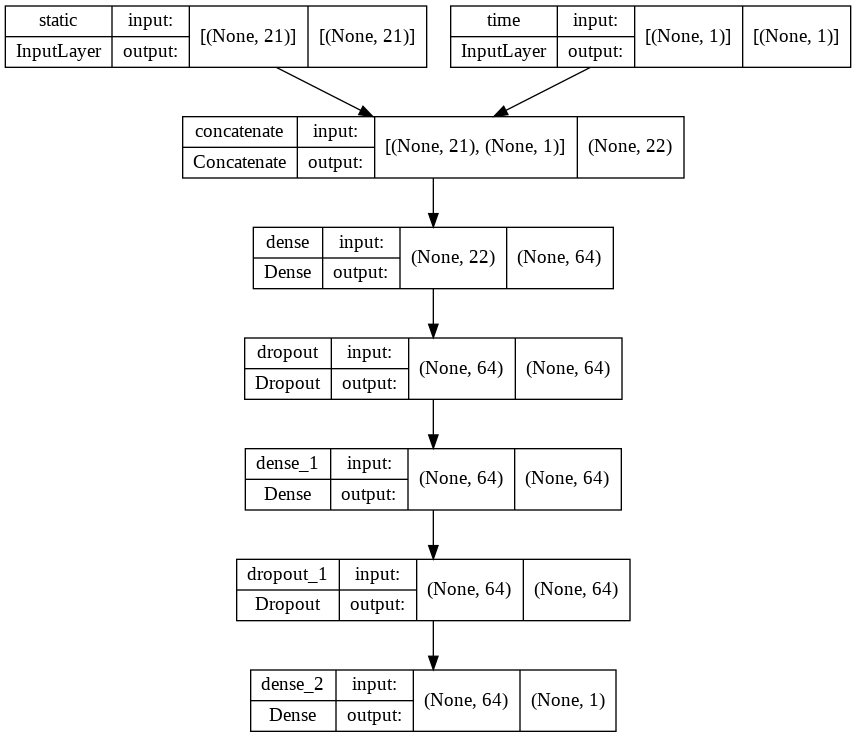

In [859]:
K.clear_session()

def create_time_model(filter_units = 64, lstm_units = 2, kernel_size = 4, dense_units = 64, dr = .2 ):
    input0 = Input(shape = (train_static.shape[1],), name = 'static')
    input1 = Input(shape = (1), name = 'time')
   #x = conv_block(input1,filter_units, kernel_size, dr)                                                            
    #x = lstm_block(input1, lstm_units, dr)
    
    x = Concatenate()([input0, input1])
    x = dense_block(x, dense_units, dr)
    #x = Flatten()(x)
    
    out = Dense(1)(x)
    model = Model(inputs = [input0,input1], outputs = out)

    return model
nadam = tf.keras.optimizers.Nadam(learning_rate=.001)
rmsprop = tf.keras.optimizers.RMSprop(learning_rate = .001, momentum=.9)
model = create_time_model()
model.compile(loss = create_smape(), optimizer = 'adam', metrics = ['mae','mse', create_smape()])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [860]:
early_stopping = EarlyStopping(patience = 5, restore_best_weights= True)
history = model.fit(x = {'static':train_static, 'time':train_windows}, y= train_targets, shuffle = True,
                    validation_data = [{'static':valid_static, 'time':valid_windows}, valid_targets], 
                    batch_size = g.batch_size, epochs = 100, callbacks = early_stopping)

Epoch 1/100
1463/1463 [==============================] - 7s 4ms/step - loss: 82.8985 - mae: 0.4188 - mse: 0.6883 - smape: 80.5172 - val_loss: 46.5870 - val_mae: 0.3498 - val_mse: 0.9421 - val_smape: 44.2657
Epoch 2/100
1463/1463 [==============================] - 5s 3ms/step - loss: 43.0649 - mae: 0.2533 - mse: 0.4359 - smape: 40.7640 - val_loss: 40.6790 - val_mae: 0.3337 - val_mse: 0.8928 - val_smape: 38.4103
Epoch 3/100
1463/1463 [==============================] - 5s 3ms/step - loss: 38.3372 - mae: 0.2471 - mse: 0.4768 - smape: 36.1195 - val_loss: 38.5379 - val_mae: 0.3218 - val_mse: 0.8590 - val_smape: 36.3896
Epoch 4/100
1463/1463 [==============================] - 4s 3ms/step - loss: 36.1476 - mae: 0.2356 - mse: 0.4467 - smape: 34.0869 - val_loss: 38.2163 - val_mae: 0.3214 - val_mse: 0.8633 - val_smape: 36.2566
Epoch 5/100
1463/1463 [==============================] - 4s 3ms/step - loss: 35.0662 - mae: 0.2314 - mse: 0.4034 - smape: 33.2180 - val_loss: 37.0309 - val_mae: 0.3316 - va

In [861]:
def plot_model_perf(history, metric = None):
  plt.subplots(len([metric]), 1, figsize=(12, 8))
  epochs = range(len(history.history['loss']))
  plt.plot( epochs, history.history['loss'],color = 'blue', label = 'loss' )
  plt.plot(epochs, history.history['val_loss'], color = 'red', label = 'val_loss' )
  plt.legend()
  plt.show()
  if metric:
    for i, metric in enumerate(metric):
      plt.figure(figsize=(12, 8))
      plt.plot( epochs, history.history[f'{metric}'],color = 'green', label = f'{metric}' )
      plt.plot(epochs, history.history[f'val_{metric}'], color = 'orange', label = f'val_{metric}' )
      plt.legend()
      plt.show()

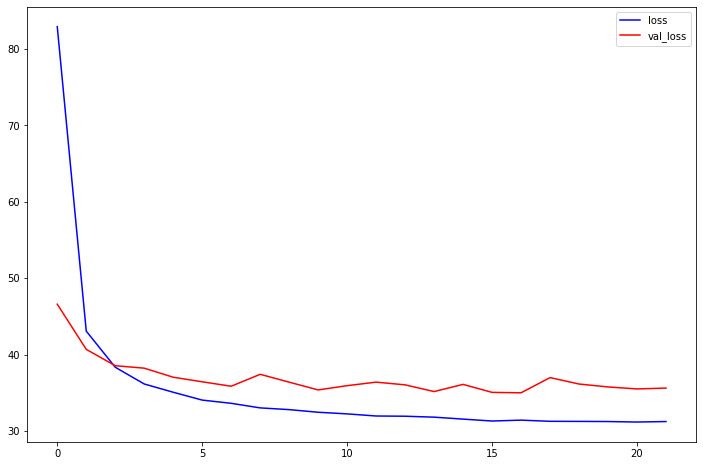

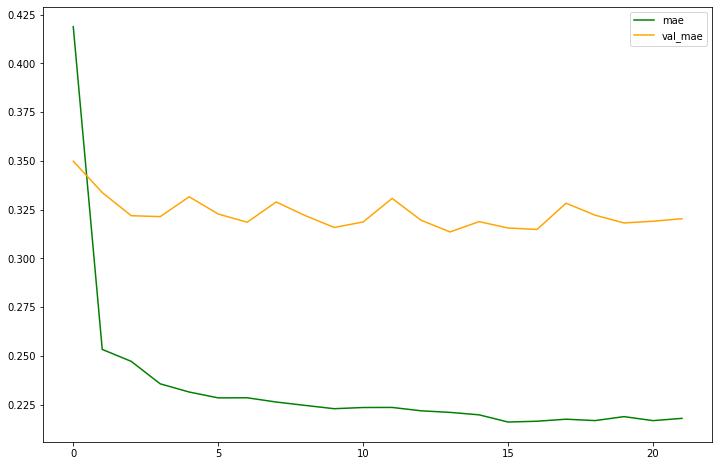

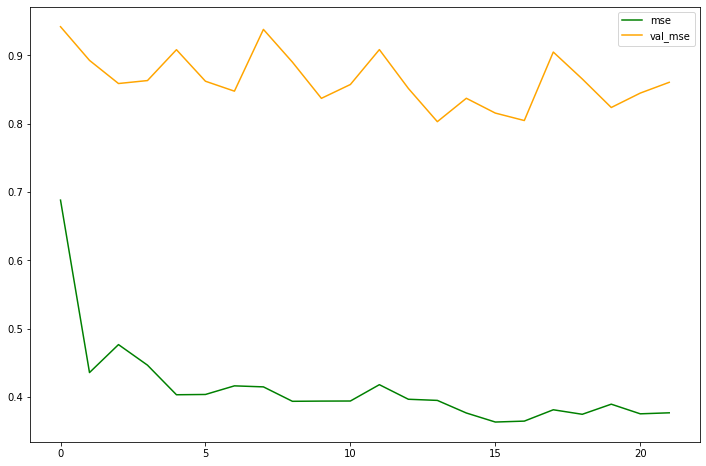

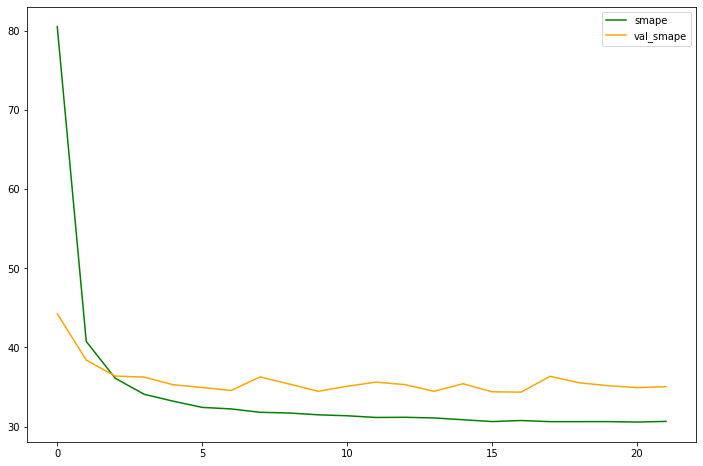

256/256 [==============================] - 1s 3ms/step - loss: 34.9936 - mae: 0.3148 - mse: 0.8048 - smape: 34.3616


[34.99361038208008, 0.3148256242275238, 0.8047824501991272, 34.36164093017578]

In [862]:
plot_model_perf(history, ['mae','mse','smape'])
model.evaluate({'static':valid_static, 'time':valid_windows}, valid_targets)

In [863]:
def plot_predictions(data, dict_number, model = model):
  plt.figure(figsize = (20, 8))
  test_batch = data[dict_number].iloc[:,:-1]
  targets = data[dict_number].iloc[:,-1].values
  test_pred = model.predict(test_batch)
  vline = np.linspace(0, test_pred.shape[0], test_pred.shape[0])
  plt.plot(vline, test_pred.reshape(-1), color = 'red', label = 'Prediction')
  plt.plot(vline, targets.reshape(-1), color = 'green', label = 'Actual')
  plt.title(f'Prediction vs. actual for validation dataset {dict_number}')
  plt.xlabel("Week")
  plt.ylabel("Value")
  plt.legend()
  plt.show()

(22, 64)


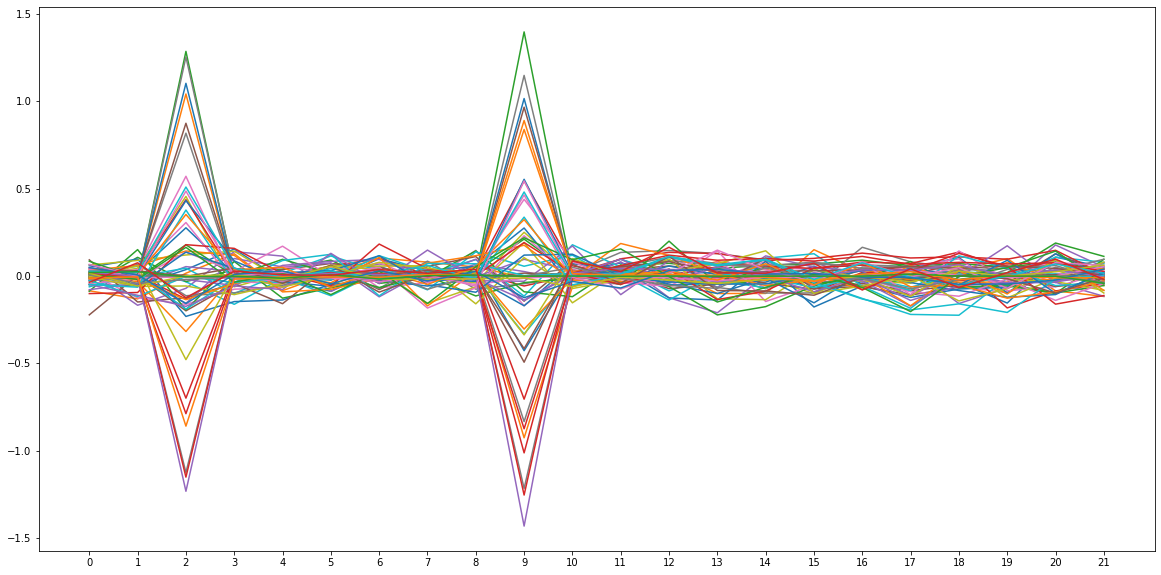

In [864]:
x = np.squeeze(model.layers[3].get_weights()[0])
print(x.shape)
plt.figure(figsize = (20,10))
plt.xticks(range(0,x.shape[0]))
#plt.yscale('log')
plt.plot(x)

(64,)


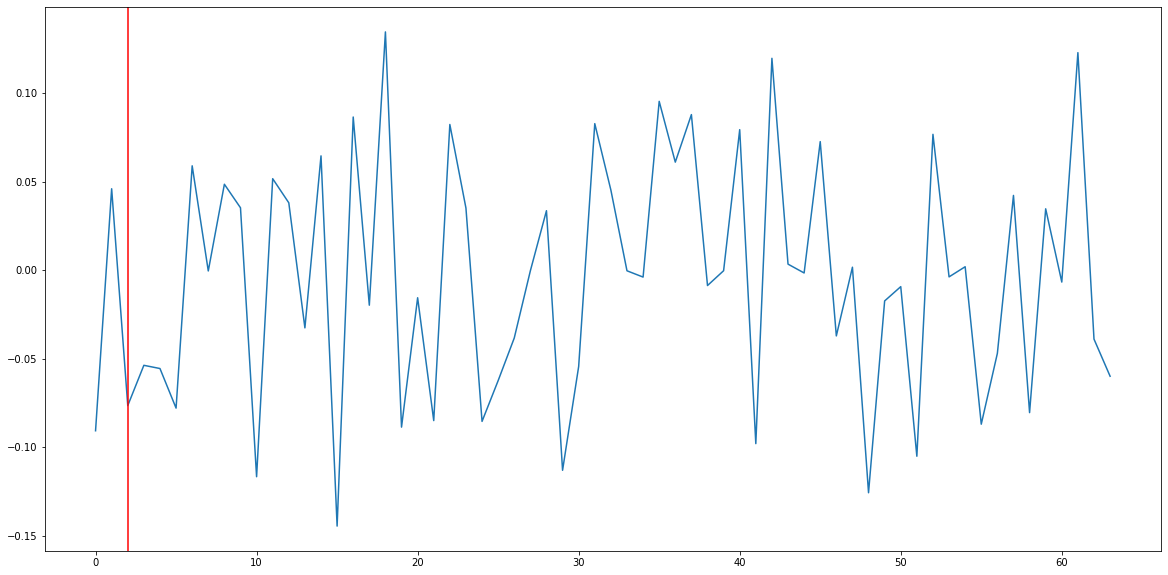

In [865]:
x = np.squeeze(model.layers[-1].get_weights()[0])
print(x.shape)
plt.figure(figsize = (20,10))
#plt.yscale('log')
plt.plot(x)
plt.axvline(x = 2, color = 'r')

In [866]:
for i in range(0, 3):
  plot_predictions(valid_scaled, i)

ValueError: ignored

<Figure size 1440x576 with 0 Axes>

In [ ]:
for i in range(0,5):
  plot_predictions(valid_scaled, np.random.randint(0, len(valid_scaled)))